<a href="https://colab.research.google.com/github/cmnemoi/ProjetDataScienceLPSID/blob/main/src/Choix_mod%C3%A8les.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Projet Data Science - Choix des modèles de machine learning
### Enzo Risbetz et Charles-Meldhine MADI MNEMOI


Dans ce notebook, nous allons créer des modèles.

### Import des packages et des données


In [1]:
!pip install "ray[tune]" tune-sklearn -q #librarie permettant d'utiliser le GPU pour chercher les hyperparamètres
!pip install scikit-learn-intelex -q #librarie permettant d'utiliser la version Intel de certaines fonctions Scikit-learn, 10 à 100 fois plus rapide
!pip install scikit-optimize -q

     |████████████████████████████████| 54.5 MB 227 kB/s 
     |████████████████████████████████| 40 kB 5.9 MB/s 
     |████████████████████████████████| 8.8 MB 55.9 MB/s 
     |████████████████████████████████| 4.1 MB 52.8 MB/s 
     |████████████████████████████████| 144 kB 60.5 MB/s 
     |████████████████████████████████| 125 kB 82.3 MB/s 
     |████████████████████████████████| 461 kB 57.6 MB/s 
     |████████████████████████████████| 69 kB 3.2 MB/s 
     |████████████████████████████████| 22.5 MB 1.7 MB/s 
     |████████████████████████████████| 284.3 MB 2.1 kB/s 
     |████████████████████████████████| 4.0 MB 52.9 MB/s 
     |████████████████████████████████| 100 kB 3.6 MB/s 


In [ ]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns


sns.set()
np.random.seed(0)

In [3]:
dataset = pd.read_csv(
    "https://raw.githubusercontent.com/cmnemoi/ProjetDataScienceLPSID/main/data/explored_dataset.csv"
)

In [4]:
dataset.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,total_amount,PULocationLabel,DOLocationLabel,day,hour,is_sunday,is_night_trip,airport_trip
0,1.0,2020-05-01 16:25:12,2020-05-01 16:45:33,1.0,4.30,N,234,256,1.0,23.98,Union Sq,Williamsburg (South Side),1,16,0,0,0
1,2.0,2020-05-06 12:58:26,2020-05-06 13:16:11,5.0,3.89,N,234,256,1.0,22.56,Union Sq,Williamsburg (South Side),6,12,0,0,0
2,1.0,2020-05-06 17:22:10,2020-05-06 17:38:17,1.0,3.80,N,234,256,1.0,21.80,Union Sq,Williamsburg (South Side),6,17,0,0,0
3,2.0,2020-05-07 13:03:37,2020-05-07 13:21:53,2.0,4.97,N,234,256,1.0,24.36,Union Sq,Williamsburg (South Side),7,13,0,0,0
4,1.0,2020-05-10 02:10:27,2020-05-10 02:25:07,1.0,4.10,N,234,256,2.0,19.30,Union Sq,Williamsburg (South Side),10,2,1,1,0


In [5]:
X = dataset.drop(
    [
        "tpep_pickup_datetime",
        "tpep_dropoff_datetime",
        "PULocationLabel",
        "store_and_fwd_flag",
        "DOLocationLabel",
        "total_amount",
    ],
    axis=1,
)
y = dataset[["total_amount"]]

### Codage des variables

In [6]:
X["VendorID"] = X["VendorID"].astype(int).astype("category")
X["passenger_count"] = X["passenger_count"].astype(int)
X["PULocationID"] = X["PULocationID"].astype(int).astype("category")
X["DOLocationID"] = X["DOLocationID"].astype(int).astype("category")
X["payment_type"] = X["payment_type"].astype(int).astype("category")
X["day"] = X["day"].astype(int).astype("category")
X["hour"] = X["hour"].astype(int).astype("category")
X["is_night_trip"] = X["is_night_trip"].astype(int).astype("category")
X["airport_trip"] = X["airport_trip"].astype(int).astype("category")

### Train test split

Nous allons maintenant partager notre dataset en un jeu de données d'entraînement, jeu de données de validation et jeu de données de test.

Le jeu d'entraînement est utilisé pour entraîner notre modèle.
 
Le jeu de validation est utilisé pour évaluer le modèle sur des données qu'il ne connaît pas, optimiser les hyperparamètres et comparer les modèles entre eux afin de choisir le plus performant.
 
Le jeu de test est utilssé pour évaluer notre modèle final et s'assurer qu'il a bien appris quelque chose de pertinent. 
 
(Il ne faut jamais utiliser le jeu de test pour comparer des modèles)
 
Il est nécessaire de faire ainsi afin d'éviter que nos modèles ne soient trop ajustés aux données (overfitting) et se généralise aux nouvelles données.

On alloue 70% des données au jeu d'entraînement et 30% au jeu de test (proportion recommandée par la littérature scientifique) :

In [7]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

X_train.reset_index(inplace=True, drop=True)
X_test.reset_index(inplace=True, drop=True)
y_train.reset_index(inplace=True, drop=True)
y_test.reset_index(inplace=True, drop=True)

y_train.columns = ["total_amount"]
y_test.columns = ["total_amount"]

In [8]:
print(X_train.size, X_test.size)

2075788 889636


On utilisera la technique de la validation croisée pour créer un jeu de données de validation durant la phase de modélisation.

### Préprocessing

Dans le notebook de nettoyage de données, nous avons exhibé des colonnes (`trip_distance` et `total_amount`) méritant du preprocessing :    


*   Seuil pour les valeurs extrêmes
*   Transformations non linéaires (logarithmes)...

On doit également standardiser toutes les variables pour respecter les hypothèses de certains algorithmes comme la régression linéaire.

On créé donc plusieurs sous-datasets afin d'observer l'effet de ces transformations sur la performance de nos modèles.


#### Remplacement des valeurs extrêmes par un seuil (trimming)




On remplace les valeurs supérieures au 99e centile par le 99e centile :

In [9]:
quantile = X_train["trip_distance"].quantile(q=0.99)
trimmed_X_train = X_train.copy()
trimmed_X_train["trip_distance"] = [
    quantile if x > quantile else x for x in X_train["trip_distance"]
]

trimmed_X_test = X_test.copy()
trimmed_X_test["trip_distance"] = [
    quantile if x > quantile else x for x in X_test["trip_distance"]
]

In [10]:
quantile = y_train["total_amount"].quantile(q=0.99)
trimmed_y_train = y_train.copy()
trimmed_y_train["total_amount"] = [
    quantile if y > quantile else y for y in y_train["total_amount"]
]

trimmed_y_test = y_test.copy()
trimmed_y_test["total_amount"] = [
    quantile if y > quantile else y for y in y_test["total_amount"]
]

In [11]:
def trim(column: pd.Series) -> np.array:
    """Return a pandas.Series in which each value above 99e centile is trimmed at 99e centile"""
    quantile = column.quantile(q=0.99)[0]
    return np.array(
        [quantile if x[0] > quantile else x for x in column.values], dtype="object"
    ).reshape(-1, 1)

In [12]:
from sklearn.preprocessing import FunctionTransformer

trimmer = FunctionTransformer(trim)

#### Transformation non linéaire (logarithmique)


On transforme `trip_distance` et `total_amount` par leur logarithme pour obtenir une distance plus proche de la loi normale :

In [13]:
log_X_train = X_train.copy()
log_X_train["trip_distance"] = np.log(X_train["trip_distance"])

log_X_test = X_test.copy()
log_X_test["trip_distance"] = np.log(X_test["trip_distance"])

In [14]:
log_y_train = y_train.copy()
log_y_train["total_amount"] = np.log(y_train["total_amount"])

log_y_test = y_test.copy()
log_y_test["total_amount"] = np.log(y_test["total_amount"])

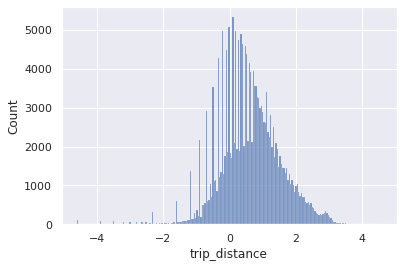

In [15]:
sns.histplot(x=log_X_train["trip_distance"])

#### Standardisation
On remplace les variables qualitatives X par : $\frac{X - \mu }{\sigma}$ avec $\mu$ la moyenne de la variable et $\sigma$ son écart-type :

In [16]:
from sklearn.preprocessing import StandardScaler

Z_score_scaler = StandardScaler().fit(X_train[["trip_distance"]])

standardized_X_train = X_train.copy()
standardized_X_train["trip_distance"] = Z_score_scaler.transform(
    X_train[["trip_distance"]]
)

standardized_X_test = X_test.copy()
standardized_X_test["trip_distance"] = Z_score_scaler.transform(
    X_test[["trip_distance"]]
)

Note : on utilisera par la suite des objets `Pipeline` pour simplifier le code et éviter encore plus le [data leakage](https://machinelearningmastery.com/data-leakage-machine-learning/).

### Modélisation

#### Préambule

On peut enfin passer à la modélisation. 

Le machine learning consiste à trouver une fonction de prédiction f telle que y = f(X).
Pour estimer f, on cherche à minimiser la fonction coût C.

Ayant à faire à un problème de régression, on a le choix, entre autres, les fonctions coût suivantes :     


*   Mean Squared Error : $MSE = \frac{1}{n} \sum_{i=1}^{n}(y-f(x_{i}))^{2}$
*   Root Mean Squared Error : $RMSE = \frac{1}{n} \sum_{i=1}^{n}\sqrt{(y-f(x_{i}))^{2}}$
*   Mean Absolute Error : $MAE = \frac{1}{n} \sum_{i=1}^{n}\left|{y-f(x_{i})}\right|$

Pour notre étude, on choisit les fonctions coût `Mean Squared Error` (MSE) et `Mean Aboslute Error` (MAE).
On notera que la MAE est moins sensible aux valeurs extrêmes que la MSE, et est de la même unité que la variable cible.


Pour comprendre et évaluer les modèles, nous allons considérer les algorithmes ML suivants :



1er choix - Régression linéaire

L'analyse de régression linéaire sert à prévoir la valeur d'une variable en fonction de la valeur d'une autre variable. Elle est utilisée pour trouver une relation linéaire entre la cible et un ou plusieurs prédicteur(s). L'idée principale est d'identifier une ligne qui s'adapte le mieux aux données. La ligne la mieux ajustée est celle pour laquelle l'erreur de prédiction est la plus faible.
 
On a alors  $y = \sum_{i=1}^{n}w_iX_i $ avec $w_i$ les coefficients de la régression et $X_i$ la variable explicative n°i.

La régression polynomiale peut être considéré comme un cas particulier de régression linéaire où l'on ajoute des variables explicatives élevés au carré, au cube, des produits de variables...



2ème choix - Arbre de décision

Un arbre de décision est un outil d'aide à la décision représentant un ensemble de choix sous la forme graphique d'un arbre. Les différentes décisions possibles sont situées aux extrémités des branches (les « feuilles » de l'arbre), et sont atteintes en fonction de décisions prises à chaque étape.

3ème choix - Random forest

Le random forest est composé de plusieurs arbres de décision, travaillant de manière indépendante sur une vision d'un problème. Chacun produit une estimation, et c'est l'assemblage des arbres de décision et de leurs analyses, qui va donner une estimation globale.

Le random forest est un modèle d'apprentissage, dont l'efficacité dépend fortement de la qualité de l'échantillon de données de départ.

Random Forest est bien plus flexible qu'un modèle de régression linéaire.

In [17]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.compose import make_column_transformer
from sklearn.pipeline import Pipeline, make_pipeline


MAE = "neg_mean_absolute_error"
MSE = "neg_mean_squared_error"

##### Validation croisée

Revenons sur la validation croisée, spécifiquement la version *K-folds*.
 
Elle consiste à séparer le jeu de données d'entraînement en K sous-ensembles. On entraîne alors le modèle à l'aide des K-1 premiers sous-ensembles et on teste (=valide) ces performances sur le K-ième.

On échange ensuite les rôles jusqu'à ce que chaque sous ensemble ait servi de jeu de validation.


<img src="https://scikit-learn.org/stable/_images/grid_search_cross_validation.png" width="400" height="277" />

On peut ainsi vérifier que le modèle n'est pas sur-ajusté par rapport aux données d'entraînement en traçant les courbes d'apprentissage :

<img src="https://1.cms.s81c.com/sites/default/files/2021-03-03/classic%20overfitting_0.jpg" width="400" height="377" />

La fonction suivante fait exactement cela : appliquer une validation croisée et tracer les courbes d'apprentissage :

In [ ]:
from sklearn.model_selection import learning_curve


def plot_learning_curve(
    estimator,
    X,
    y,
    title="Learning curves",
    score="neg_mean_absolute_error",
    axes=None,
    ylim=None,
    cv=None,
    n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 50),
):
    """
    Generate  the val and training learning curve
    Source : https://scikit-learn.org/stable/auto_examples/model_selection/plot_learning_curve.html

    Parameters
    ----------
    estimator : estimator instance
        An estimator instance implementing `fit` and `predict` methods which
        will be cloned for each validation.

    title : str
        Title for the chart.

    X : array-like of shape (n_samples, n_features)
        Training vector, where ``n_samples`` is the number of samples and
        ``n_features`` is the number of features.

    y : array-like of shape (n_samples) or (n_samples, n_features)
        Target relative to ``X`` for classification or regression;
        None for unsupervised learning.

    score: scoring object

    axes : array-like of shape (3,), default=None
        Axes to use for plotting the curves.

    ylim : tuple of shape (2,), default=None
        Defines minimum and maximum y-values plotted, e.g. (ymin, ymax).

    cv : int, cross-validation generator or an iterable, default=None
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:

          - None, to use the default 5-fold cross-validation,
          - integer, to specify the number of folds.
          - :term:`CV splitter`,
          - An iterable yielding (train, val) splits as arrays of indices.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : int or None, default=None
        Number of jobs to run in parallel.
        ``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.
        ``-1`` means using all processors. See :term:`Glossary <n_jobs>`
        for more details.

    train_sizes : array-like of shape (n_ticks,)
        Relative or absolute numbers of training examples that will be used to
        generate the learning curve. If the ``dtype`` is float, it is regarded
        as a fraction of the maximum size of the training set (that is
        determined by the selected validation method), i.e. it has to be within
        (0, 1]. Otherwise it is interpreted as absolute sizes of the training
        sets. Note that for classification the number of samples usually have
        to be big enough to contain at least one sample from each class.
        (default: np.linspace(0.1, 1.0, 5))
    """

    if axes is None:
        _, axes = plt.subplots(1, 1, figsize=(7, 7))

    axes.set_title(title)
    if ylim is not None:
        axes.set_ylim(*ylim)
    axes.set_xlabel("Training examples")
    axes.set_ylabel("Score")

    train_sizes, train_scores, val_scores, fit_times, _ = learning_curve(
        estimator,
        X,
        y,
        cv=cv,
        n_jobs=n_jobs,
        train_sizes=train_sizes,
        return_times=True,
        scoring=score,
    )
    train_scores_mean = abs(np.mean(train_scores, axis=1))
    train_scores_std = np.std(train_scores, axis=1)
    val_scores_mean = abs(np.mean(val_scores, axis=1))
    val_scores_std = np.std(val_scores, axis=1)

    # Plot learning curve
    axes.grid()
    axes.fill_between(
        train_sizes,
        train_scores_mean - train_scores_std,
        train_scores_mean + train_scores_std,
        alpha=0.1,
        color="r",
    )
    axes.fill_between(
        train_sizes,
        val_scores_mean - val_scores_std,
        val_scores_mean + val_scores_std,
        alpha=0.1,
        color="g",
    )
    axes.plot(train_sizes, train_scores_mean, "o-", color="r", label="Training score")
    axes.plot(
        train_sizes, val_scores_mean, "o-", color="g", label="Cross-validation score"
    )
    axes.legend(loc="best")

    score_to_print = score.split("_", 1)[-1]

    print(
        f"Training {score_to_print} : {train_scores_mean.mean():.3f} (+/- {train_scores_std.mean():.3f})"
    )
    print(
        f"Validation {score_to_print} : {val_scores_mean.mean():.3f} (+/- {val_scores_std.mean():.3f})"
    )

    return plt

##### GridSearchCV

In [19]:
from ray.tune.sklearn import TuneGridSearchCV

#### Régression linéaire

In [20]:
from sklearn.linear_model import LinearRegression

##### Vanilla

Training mean_absolute_error : 1.745 (+/- 0.011)
Validation mean_absolute_error : 1.737 (+/- 0.019)


<module 'matplotlib.pyplot' from '/usr/local/lib/python3.7/dist-packages/matplotlib/pyplot.py'>

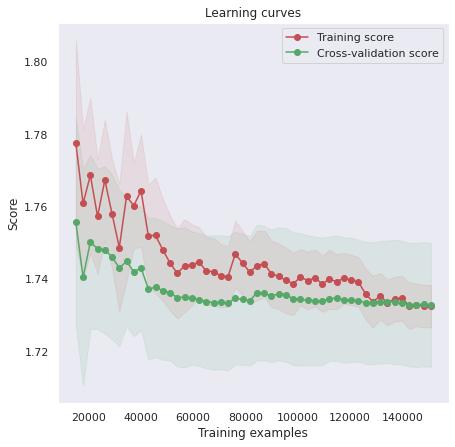

In [ ]:
plot_learning_curve(LinearRegression(n_jobs=-1), X_train, y_train, score=MAE)

Training mean_squared_error : 20.279 (+/- 1.900)
Validation mean_squared_error : 18.297 (+/- 4.306)


<module 'matplotlib.pyplot' from '/usr/local/lib/python3.7/dist-packages/matplotlib/pyplot.py'>

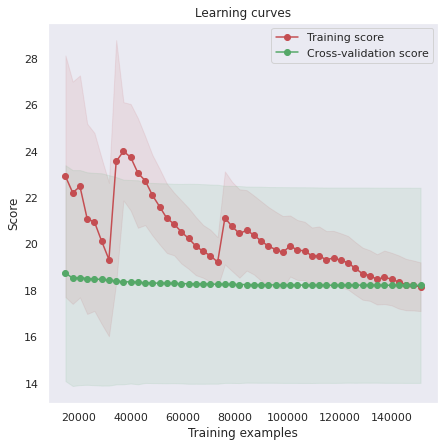

In [ ]:
plot_learning_curve(LinearRegression(n_jobs=-1), X_train, y_train, score=MSE)

##### Standardised dataset

In [22]:
standardized_linear_regression = Pipeline(
    [
        ("Z-score_scaler", StandardScaler()),
        ("linear_regression", LinearRegression(n_jobs=-1)),
    ]
)

Training mean_absolute_error : 1.745 (+/- 0.011)
Validation mean_absolute_error : 1.737 (+/- 0.019)


<module 'matplotlib.pyplot' from '/usr/local/lib/python3.7/dist-packages/matplotlib/pyplot.py'>

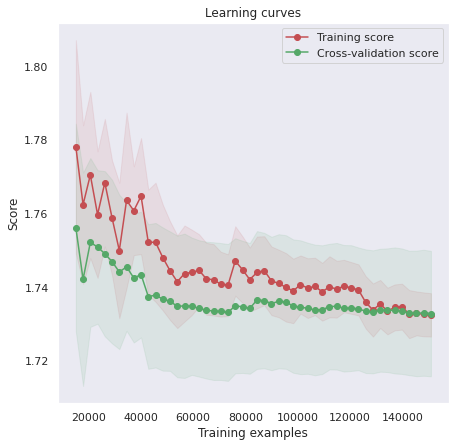

In [ ]:
plot_learning_curve(standardized_linear_regression, X_train, y_train, score=MAE)

Training mean_squared_error : 20.281 (+/- 1.901)
Validation mean_squared_error : 18.299 (+/- 4.305)


<module 'matplotlib.pyplot' from '/usr/local/lib/python3.7/dist-packages/matplotlib/pyplot.py'>

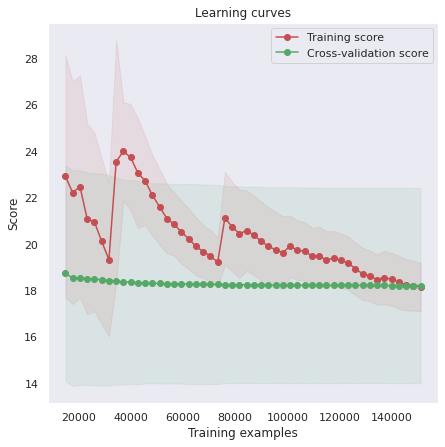

In [ ]:
plot_learning_curve(standardized_linear_regression, X_train, y_train, score=MSE)

##### Trimmed dataset

Training mean_absolute_error : 1.584 (+/- 0.004)
Validation mean_absolute_error : 1.582 (+/- 0.009)


<module 'matplotlib.pyplot' from '/usr/local/lib/python3.7/dist-packages/matplotlib/pyplot.py'>

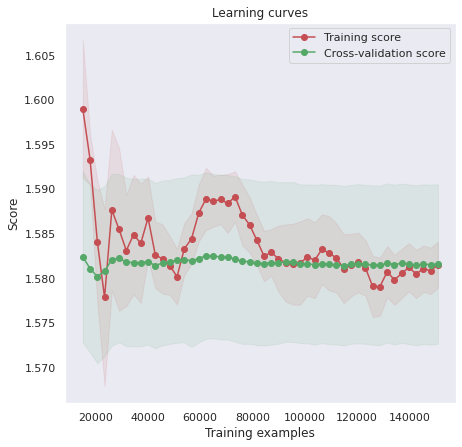

In [ ]:
plot_learning_curve(
    LinearRegression(n_jobs=-1), trimmed_X_train, trimmed_y_train, score=MAE
)

Training mean_squared_error : 8.878 (+/- 0.109)
Validation mean_squared_error : 8.768 (+/- 0.319)


<module 'matplotlib.pyplot' from '/usr/local/lib/python3.7/dist-packages/matplotlib/pyplot.py'>

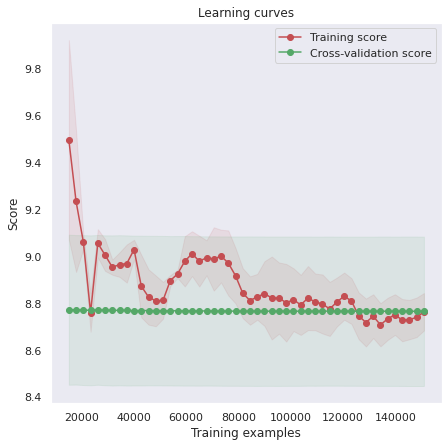

In [ ]:
plot_learning_curve(
    LinearRegression(n_jobs=-1), trimmed_X_train, trimmed_y_train, score=MSE
)

On voit que ramener les valeurs extrêmes à un seuil améliore beaucoup la MSE (de 13 points !) et peu la MAE.

La preuve que la MAE est moins sensible aux outliers.

##### Trimmed dataset + Standardization

Training mean_absolute_error : 1.583 (+/- 0.004)
Validation mean_absolute_error : 1.581 (+/- 0.009)


<module 'matplotlib.pyplot' from '/usr/local/lib/python3.7/dist-packages/matplotlib/pyplot.py'>

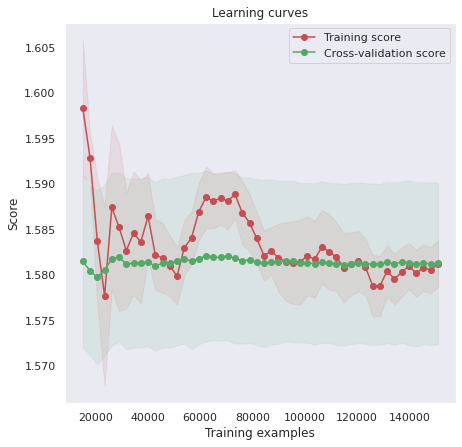

In [ ]:
plot_learning_curve(
    standardized_linear_regression, trimmed_X_train, trimmed_y_train, score=MAE
)

Training mean_squared_error : 8.880 (+/- 0.109)
Validation mean_squared_error : 8.769 (+/- 0.319)


<module 'matplotlib.pyplot' from '/usr/local/lib/python3.7/dist-packages/matplotlib/pyplot.py'>

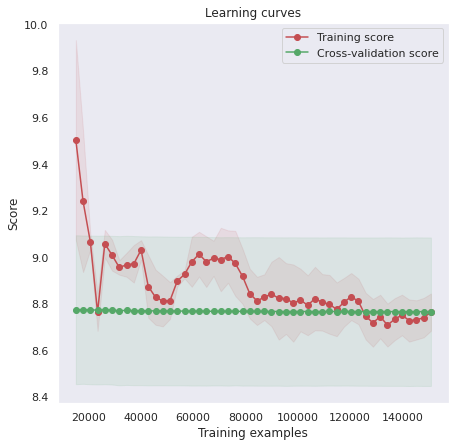

In [ ]:
plot_learning_curve(
    standardized_linear_regression, trimmed_X_train, trimmed_y_train, score=MSE
)

#### Régression polynomiale

In [ ]:
from sklearn.preprocessing import PolynomialFeatures

numeric_transformer = make_column_transformer((StandardScaler(), ["trip_distance"]))
poly_reg = make_pipeline(PolynomialFeatures(degree=2), LinearRegression(n_jobs=-1))

Training mean_absolute_error : 1.486 (+/- 0.005)
Validation mean_absolute_error : 1.498 (+/- 0.013)


<module 'matplotlib.pyplot' from '/usr/local/lib/python3.7/dist-packages/matplotlib/pyplot.py'>

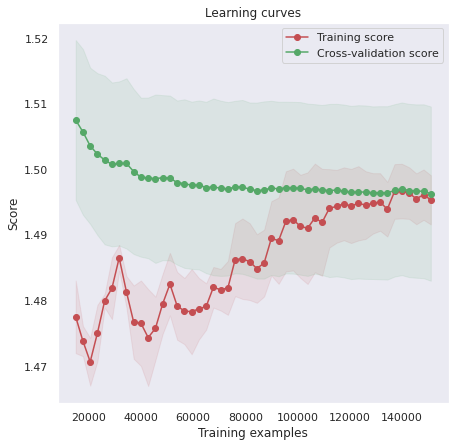

In [ ]:
plot_learning_curve(
    poly_reg, trimmed_X_train, trimmed_y_train, train_sizes=np.linspace(0.1, 1, 50)
)

/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:705: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


Training mean_absolute_error : 1.464 (+/- 0.005)
Validation mean_absolute_error : 1.486 (+/- 0.012)


<module 'matplotlib.pyplot' from '/usr/local/lib/python3.7/dist-packages/matplotlib/pyplot.py'>

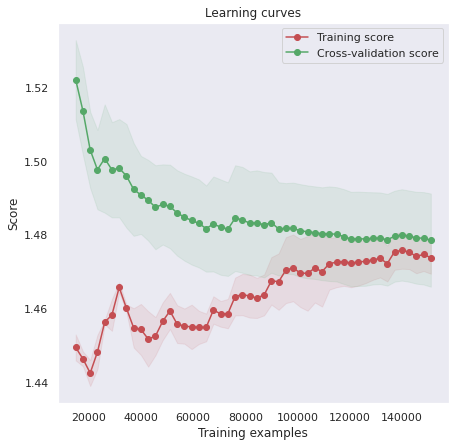

In [ ]:
poly_3_reg = make_pipeline(PolynomialFeatures(degree=3), LinearRegression(n_jobs=-1))
plot_learning_curve(
    poly_3_reg, trimmed_X_train, trimmed_y_train, train_sizes=np.linspace(0.1, 1, 50)
)

#### Arbre de décision

In [ ]:
from sklearn.tree import DecisionTreeRegressor

##### Vanilla

In [ ]:
vanilla_tree = DecisionTreeRegressor(criterion="absolute_error", random_state=0)

Training mean_absolute_error : 0.001 (+/- 0.000)
Validation mean_absolute_error : 10.363 (+/- 0.144)


<module 'matplotlib.pyplot' from '/usr/local/lib/python3.7/dist-packages/matplotlib/pyplot.py'>

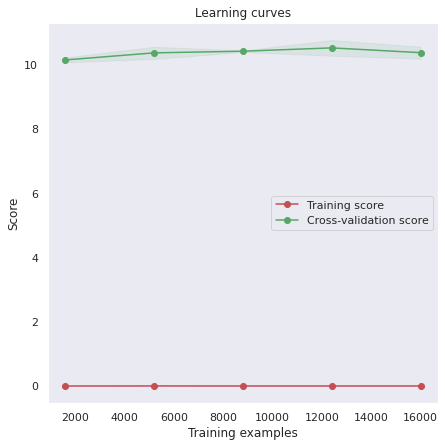

In [ ]:
plot_learning_curve(
    vanilla_tree,
    X_train,
    y_train.sample(20000),
    score=MAE,
    train_sizes=np.linspace(0.1, 1, 5),
)

On voit qu'on est clairement en sur-ajustement : le modèle explique très bien le jeu d'entraînement mais pas du tout le jeu de validation.

##### GridSearchCV

On utilise une grille de recherche pour optimiser les [hyperparamètres](https://towardsdatascience.com/kagglers-guide-to-lightgbm-hyperparameter-tuning-with-optuna-in-2021-ed048d9838b5) du modèle.

Une grille de recherche permet de tester automatiquement tous les combinaisons des hyperparamètre et ne garder que celles avec le meilleur score en validation croisée, càd celels qui parviennent à créer un modèle qui se généralise bien.

La profondeur maximale de l'arbre `max_depth` est un facteur majeur de sur-ajustement. En effet, plus l'arbre est profond, plus il peut coller aux données et donc être surajusté.
On le limite donc à 12 maximum.

In [ ]:
vanilla_tree = DecisionTreeRegressor(criterion="squared_error", random_state=0)

parameters = dict(max_depth=np.arange(3, 12, 1))

CV_tree = TuneGridSearchCV(
    vanilla_tree, parameters, scoring=MSE, n_jobs=-1, cv=3, use_gpu=True
)

In [ ]:
print(CV_tree.fit(trimmed_X_train, trimmed_y_train).best_estimator_)

2022-06-05 10:06:38,017	INFO trial_runner.py:803 -- starting _Trainable_2e76b_00000
2022-06-05 10:06:41,278	INFO trial_runner.py:803 -- starting _Trainable_2e76b_00001
2022-06-05 10:06:41,835	INFO trial_runner.py:803 -- starting _Trainable_2e76b_00002
2022-06-05 10:06:42,514	INFO trial_runner.py:803 -- starting _Trainable_2e76b_00003
2022-06-05 10:06:43,301	INFO trial_runner.py:803 -- starting _Trainable_2e76b_00004
2022-06-05 10:06:44,186	INFO trial_runner.py:803 -- starting _Trainable_2e76b_00005
2022-06-05 10:06:45,158	INFO trial_runner.py:803 -- starting _Trainable_2e76b_00006
2022-06-05 10:06:46,234	INFO trial_runner.py:803 -- starting _Trainable_2e76b_00007
2022-06-05 10:06:47,413	INFO trial_runner.py:803 -- starting _Trainable_2e76b_00008


DecisionTreeRegressor(max_depth=8, random_state=0)


On obtient une valeur optimale de 8. 

D'après cet [article](https://towardsdatascience.com/kagglers-guide-to-lightgbm-hyperparameter-tuning-with-optuna-in-2021-ed048d9838b5), on peut ainsi régler un autre paramètre important pour gérer le sur-ajustement `max_leaf_nodes`, le nombre maximal de feuilles dans l'arbre, à 2^8 maximum.

In [ ]:
parameters = {"max_leaf_nodes": np.arange(2**3, 2**8, 10), "max_depth": [8]}
CV_tree = TuneGridSearchCV(
    vanilla_tree, parameters, n_jobs=-1, cv=3, scoring=MSE, use_gpu=True
)

In [ ]:
CV_tree.fit(trimmed_X_train, trimmed_y_train).best_estimator_

2022-06-05 10:08:08,086	INFO trial_runner.py:803 -- starting _Trainable_65c40_00000
2022-06-05 10:08:10,806	INFO trial_runner.py:803 -- starting _Trainable_65c40_00001
2022-06-05 10:08:11,509	INFO trial_runner.py:803 -- starting _Trainable_65c40_00002
2022-06-05 10:08:12,295	INFO trial_runner.py:803 -- starting _Trainable_65c40_00003
2022-06-05 10:08:13,130	INFO trial_runner.py:803 -- starting _Trainable_65c40_00004
2022-06-05 10:08:13,993	INFO trial_runner.py:803 -- starting _Trainable_65c40_00005
2022-06-05 10:08:14,872	INFO trial_runner.py:803 -- starting _Trainable_65c40_00006
2022-06-05 10:08:15,781	INFO trial_runner.py:803 -- starting _Trainable_65c40_00007
2022-06-05 10:08:16,682	INFO trial_runner.py:803 -- starting _Trainable_65c40_00008
2022-06-05 10:08:17,603	INFO trial_runner.py:803 -- starting _Trainable_65c40_00009
2022-06-05 10:08:18,592	INFO trial_runner.py:803 -- starting _Trainable_65c40_00010
2022-06-05 10:08:19,537	INFO trial_runner.py:803 -- starting _Trainable_65c4

DecisionTreeRegressor(max_depth=8, max_leaf_nodes=218, random_state=0)

Intégrons ses valeurs optimales dans notre modèle et évaluons le :

Training mean_squared_error : 7.009 (+/- 0.151)
Validation mean_squared_error : 8.521 (+/- 0.402)


<module 'matplotlib.pyplot' from '/usr/local/lib/python3.7/dist-packages/matplotlib/pyplot.py'>

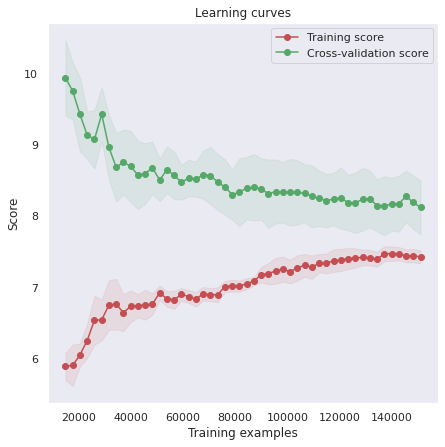

In [ ]:
CV_tree = DecisionTreeRegressor(
    criterion="squared_error", max_depth=8, max_leaf_nodes=218, random_state=0
)
plot_learning_curve(
    CV_tree,
    trimmed_X_train,
    trimmed_y_train,
    score=MSE,
    train_sizes=np.linspace(0.1, 1, 50),
)

Même s'il reste un leger sur-ajustement, c'est déjà beaucoup mieux. Les arbres ayant tendance à sur-ajuster facilement, passons à un autre modèle : les forêts aléatoires.

#### Random forest

In [ ]:
from sklearn.ensemble import RandomForestRegressor

parameters = {"max_leaf_nodes": np.arange(30, 2000, 100)}
vanilla_rf = RandomForestRegressor(
    n_estimators=100, criterion="squared_error", random_state=0
)

vanilla_rf = TuneGridSearchCV(
    vanilla_rf, parameters, n_jobs=-1, cv=3, early_stopping=True, max_iters=10
)

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [ ]:
vanilla_rf.fit(trimmed_X_train, trimmed_y_train).best_estimator_

2022-06-05 10:27:40,702	INFO trial_runner.py:803 -- starting _Trainable_20b2b_00000
(_Trainable pid=2167) /usr/local/lib/python3.7/dist-packages/daal4py/sklearn/ensemble/_forest.py:502: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
(_Trainable pid=2167)   X, y, sample_weight=sample_weight)
(_Trainable pid=2167) /usr/local/lib/python3.7/dist-packages/daal4py/sklearn/ensemble/_forest.py:502: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
(_Trainable pid=2167)   X, y, sample_weight=sample_weight)
(_Trainable pid=2167) /usr/local/lib/python3.7/dist-packages/daal4py/sklearn/ensemble/_forest.py:502: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
(_Trainable pid=2167)   X, 

RandomForestRegressor(max_leaf_nodes=430, n_estimators=10, random_state=0)

Training mean_absolute_error : 1.431 (+/- 0.006)
Validation mean_absolute_error : 1.485 (+/- 0.012)


<module 'matplotlib.pyplot' from '/usr/local/lib/python3.7/dist-packages/matplotlib/pyplot.py'>

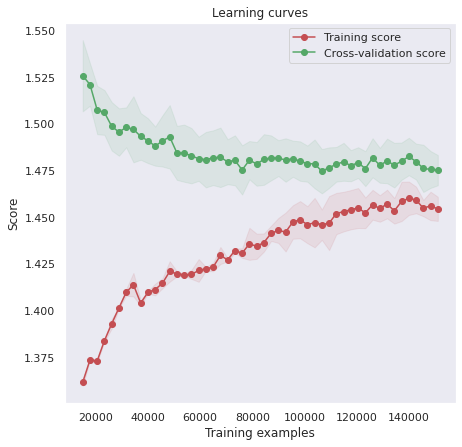

In [ ]:
plot_learning_curve(
    RandomForestRegressor(
        n_estimators=10,
        max_leaf_nodes=430,
        max_depth=np.log2(430),
        criterion="squared_error",
        random_state=0,
    ),
    trimmed_X_train,
    trimmed_y_train,
    train_sizes=np.linspace(0.1, 1, 50),
)

Training mean_squared_error : 6.905 (+/- 0.123)
Validation mean_squared_error : 7.912 (+/- 0.357)


<module 'matplotlib.pyplot' from '/usr/local/lib/python3.7/dist-packages/matplotlib/pyplot.py'>

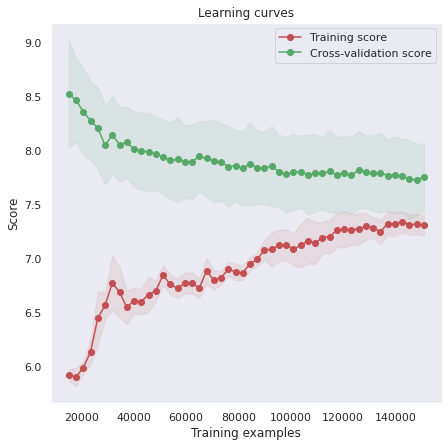

In [ ]:
plot_learning_curve(
    RandomForestRegressor(
        n_estimators=10,
        max_leaf_nodes=430,
        max_depth=np.log2(430),
        criterion="squared_error",
        random_state=0,
    ),
    trimmed_X_train,
    trimmed_y_train,
    score=MSE,
    train_sizes=np.linspace(0.1, 1, 50),
)

On voit qu'on est légèrement en sur-ajustement.

##### Variable selection

On effectue de la sélection de variables en ne conservant que les variables avec une importance supérieure à l'importance médiane et celles qui expliquent mieux les données qu'une variable aléatoire en espérant améliorer les performances du modèle.

In [ ]:
# create a random variable
random_variable = pd.Series(
    [np.random.randn() for i in range(X_train.shape[0])], name="noise"
)

rf = RandomForestRegressor(n_estimators=100, random_state=0).fit(
    pd.concat([trimmed_X_train, random_variable], axis=1), trimmed_y_train
)

/usr/local/lib/python3.7/dist-packages/daal4py/sklearn/ensemble/_forest.py:973: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



In [ ]:
feature_importances = pd.Series(rf.feature_importances_, index=rf.feature_names_in_)
feature_importances

VendorID           0.003102
passenger_count    0.002524
trip_distance      0.892931
PULocationID       0.018307
DOLocationID       0.016228
payment_type       0.022478
day                0.012079
hour               0.011236
is_sunday          0.000851
is_night_trip      0.000153
airport_trip       0.001143
noise              0.018967
dtype: float64

In [ ]:
feature_importances[feature_importances > feature_importances.median()]

trip_distance    0.892931
PULocationID     0.018307
DOLocationID     0.016228
payment_type     0.022478
day              0.012079
noise            0.018967
dtype: float64

Les seules variables plus importantes que le bruit sont `trip_distance` et `payment_type`

In [ ]:
important_variables = ["trip_distance", "payment_type"]
greater_than_median_variables = feature_importances[
    feature_importances > feature_importances.median()
].index.drop("noise")

parameters = {"max_leaf_nodes": np.arange(30, 2000, 100)}

rf = TuneGridSearchCV(
    RandomForestRegressor(n_estimators=100, random_state=0),
    parameters,
    cv=3,
    n_jobs=-1,
    early_stopping=True,
    max_iters=10,
    scoring=MSE,
)

In [ ]:
rf.fit(trimmed_X_train[important_variables], trimmed_y_train).best_estimator_

2022-06-06 10:15:16,353	INFO trial_runner.py:803 -- starting _Trainable_8e6dc_00000
2022-06-06 10:15:16,505	INFO trial_runner.py:803 -- starting _Trainable_8e6dc_00001
(_Trainable pid=2209) /usr/local/lib/python3.7/dist-packages/daal4py/sklearn/ensemble/_forest.py:502: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
(_Trainable pid=2209)   X, y, sample_weight=sample_weight)
(_Trainable pid=2211) /usr/local/lib/python3.7/dist-packages/daal4py/sklearn/ensemble/_forest.py:502: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
(_Trainable pid=2211)   X, y, sample_weight=sample_weight)
(_Trainable pid=2209) /usr/local/lib/python3.7/dist-packages/daal4py/sklearn/ensemble/_forest.py:502: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change th

RandomForestRegressor(max_leaf_nodes=130, n_estimators=10, random_state=0)

Training mean_squared_error : 8.069 (+/- 0.139)
Validation mean_squared_error : 8.247 (+/- 0.196)


<module 'matplotlib.pyplot' from '/usr/local/lib/python3.7/dist-packages/matplotlib/pyplot.py'>

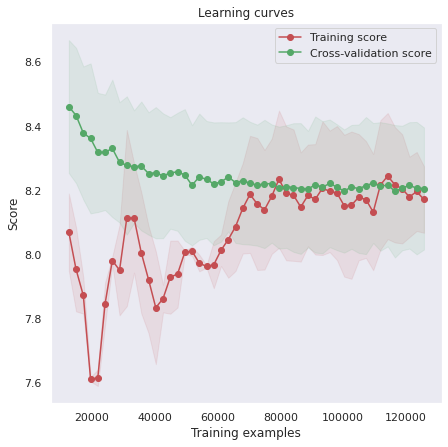

In [ ]:
plot_learning_curve(
    RandomForestRegressor(max_leaf_nodes=130, n_estimators=10, random_state=0),
    trimmed_X_train[important_variables],
    trimmed_y_train,
    cv=3,
    n_jobs=-1,
    score=MSE,
)

In [ ]:
rf.fit(trimmed_X_train[greater_than_median_variables], trimmed_y_train).best_estimator_

2022-06-06 10:29:27,178	INFO trial_runner.py:803 -- starting _Trainable_89ce8_00000
2022-06-06 10:29:27,287	INFO trial_runner.py:803 -- starting _Trainable_89ce8_00001
(_Trainable pid=2852) /usr/local/lib/python3.7/dist-packages/daal4py/sklearn/ensemble/_forest.py:502: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
(_Trainable pid=2852)   X, y, sample_weight=sample_weight)
(_Trainable pid=2857) /usr/local/lib/python3.7/dist-packages/daal4py/sklearn/ensemble/_forest.py:502: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
(_Trainable pid=2857)   X, y, sample_weight=sample_weight)
(_Trainable pid=2852) /usr/local/lib/python3.7/dist-packages/daal4py/sklearn/ensemble/_forest.py:502: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change th

RandomForestRegressor(max_leaf_nodes=330, n_estimators=10, random_state=0)

Training mean_squared_error : 7.010 (+/- 0.159)
Validation mean_squared_error : 8.071 (+/- 0.224)


<module 'matplotlib.pyplot' from '/usr/local/lib/python3.7/dist-packages/matplotlib/pyplot.py'>

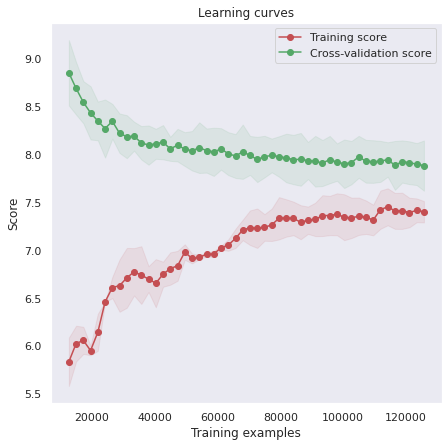

In [ ]:
plot_learning_curve(
    RandomForestRegressor(
        max_leaf_nodes=330, max_depth=np.log2(330), n_estimators=10, random_state=0
    ),
    trimmed_X_train[greater_than_median_variables],
    trimmed_y_train,
    cv=3,
    n_jobs=-1,
    score=MSE,
)

La sélection de variables n'améliore pas tellement la performance des modèles.

### Interprétations

Tous les modèles ont eu des performances similaires (entre 1.4 et 1.5 de MAE et 8 et 9 de MSE). 

En vertu du rasoir d'Ockham qui stipule qu'à niveau d'explication égale, les modèles les plus simples sont à privilégier, nous choisissons donc de garder la régression linéaire.

Cela sera également plus simple afin d'interpréter les résultats.


In [23]:
standardized_linear_regression.fit(trimmed_X_train, trimmed_y_train)

Pipeline(steps=[('Z-score_scaler', StandardScaler()),
                ('linear_regression', LinearRegression(n_jobs=-1))])

In [24]:
print(
    f"R² sur le test set : {standardized_linear_regression.score(trimmed_X_test, trimmed_y_test)}"
)
print(
    f"MAE sur le test set : {mean_absolute_error(standardized_linear_regression.predict(trimmed_X_test), trimmed_y_test)}"
)
print(
    f"MSE sur le test set : {mean_squared_error(standardized_linear_regression.predict(trimmed_X_test), trimmed_y_test)}"
)

R² sur le test set : 0.9088119742355107
MAE sur le test set : 1.5815156052456345
MSE sur le test set : 8.735326215377269


On observe que notre modèle prédit environ 90.8% de la variance du prix grâce au R².
 
De plus il y a un écart moyen d'environ 1,58$ entre notre prédiction et la vraie valeur (MAE).

Ce qui représente de très bons scores.

In [26]:
coefficients = pd.DataFrame(
    standardized_linear_regression.named_steps["linear_regression"].coef_,
    columns=standardized_linear_regression[:-1].get_feature_names_out(),
).transpose()
coefficients.columns = ["Xi"]

In [29]:
coefficients

,Xi
VendorID,-0.036089
passenger_count,0.002973
trip_distance,9.178562
PULocationID,0.183943
DOLocationID,0.143510
payment_type,-1.276800
day,0.087582
hour,0.264527
is_sunday,-0.137170
is_night_trip,0.054453


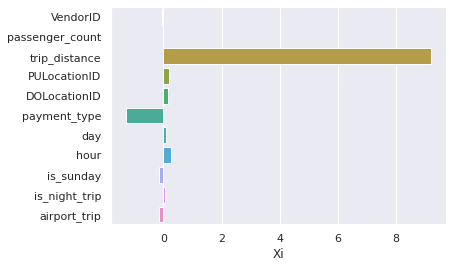

In [27]:
sns.barplot(data=coefficients, y=coefficients.index, x="Xi")

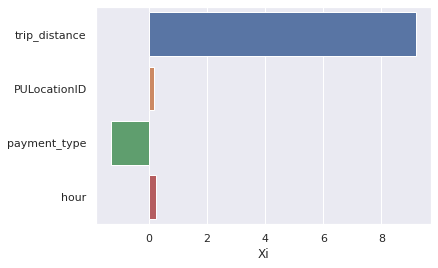

In [28]:
big_coefficients = (coefficients["Xi"] > 0.15) | (coefficients["Xi"] < -0.15)
coefficients_to_plot = coefficients[big_coefficients]
sns.barplot(data=coefficients_to_plot, y=coefficients_to_plot.index, x="Xi")

De façon sommaire, on peut remarquer que les variables qui influent le plus sur le prix du trajet sont sa distance et le moyen de paiement utilisé.

Pour rappel, on a $y = \sum_{i=1}^{n}w_i*X_i$ dans le cadre d'une régression linéaire.

On peut ainsi dire que le prix du trajet est environ égal à 9$*distance_en_miles - 1.2 dollars si on paye en espèces.



